# Test Notes in Jupyter

I am looking for a method to keep an electronic design notebook where I can keep a design log, live evqations, plots, and drawings.  Here I am trying to do this in Jupyter.

In [1]:
from sympy import *
import numpy as np
import math
from matplotlib import pyplot as plt

In [2]:
x = symbols('x')
a = Integral(cos(x)*exp(x), x)
Eq(a, a.doit())

Eq(Integral(exp(x)*cos(x), x), exp(x)*sin(x)/2 + exp(x)*cos(x)/2)

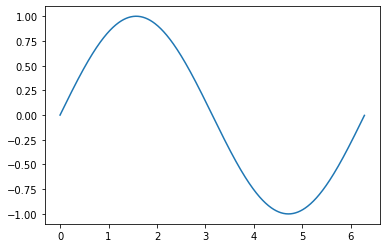

In [3]:
x = np.arange(0.0, 2*np.pi, 0.01) 
y = np.sin(x) 
plt.plot(x, y)
plt.show()

4 January 2022
- cell2d is no longer optimizing the network to minimize convolution norm
- I suspect that summing convolution weights is losing the tensor gradient 
- See [Pytorch: backpropagating from sum of matrix elements to leaf variable answer](https://stackoverflow.com/questions/55942423/pytorch-backpropagating-from-sum-of-matrix-elements-to-leaf-variable)
- Next: build up architecture loss concatenating tensors from lower networl level: c = torch.cat([a,b])
- Next: solve architecture level using torch sum: d = torch.sum(c)
- Next: verify gradient throughout operation
- Next: test convolution minimization
- Next: enable residual bypass of a specific level

6 January 2022
- Pruning successful
- Failied to run with pruned network nas_20220104_01:\
- Exception has occurred: RuntimeError       (note: full exception trace is shown but execution is paused at: <module>)
Given groups=1, weight of size [982, 1023, 1, 1], expected input[256, 1024, 8, 8] to have 1023 channels, but got 1024 channels instead
- The pruned convolution size is not fully propegated to the next convolution from Cell->ConvBR


7 January 2022
- Test cross entropy loss is ~ 0.01
- Architecture loss is ~ 0.01
- The architecture reduction pushing from 0.1 to 0.01 requests a much smaller model but has a very small loss
- Change from mean squared error to absolute error
<br /> ![Tensorboard](../img/Tensorboard_nas_20220106_01.png) <br />
- How to boost baseline accuracy to the state of the art? 
- [Cutmix](https://openaccess.thecvf.com/content_ICCV_2019/papers/Yun_CutMix_Regularization_Strategy_to_Train_Strong_Classifiers_With_Localizable_Features_ICCV_2019_paper.pdf)
- [Attentive CutMix](https://arxiv.org/pdf/2003.13048.pdf)
- [Label smoothing](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.pdf)
- [Mish activation function](https://arxiv.org/pdf/1908.08681v3.pdf)
- Comminting out Cell::ApplyStructure enabled training following pruning: <br />
            #if self.convolutions[-1]['out_channels'] == self.in1_channels+self.in2_channels:
            #    self.conv_residual = None
- On second ApplyStructure call, I get the following error: <br />
  File "networks/cell2d.py", line 164, in ApplyStructure
    raise ValueError("len(out_channel_mask)={} must be equal to self.out_channels={}".format(len(out_channel_mask), self.out_channels))
ValueError: len(out_channel_mask)=253 must be equal to self.out_channels=256
- Find why self.out_channels is not updated in second training?
- Found and fixed incorrect self.out_channels propagation on pruned cells
- Training after prune resulted in all of the higher level convolutions being pruned out.
- With higher levels pruned, the test accuracy peeked at about 50% rather than ~ 80%
<br /> ![nas_20220106_03 training Tensorboard](../img/class_weights_nas_20220106_03.png) <br />
<br /> ![nas_20220106_03 training Tensorboard](../img/TrainingAfterPrune_nas_20220106_03.png) <br />
- Why did the test accuracy peek earlier in a pruned network while the training accuracy continued to climb with just the lower level convolutions?
- What in the deeper network structure enables the training and test accuracies to track better?
- Can I capture that good to keep the training and test accuracy together for longer?
- Try reducing size by reducing convolutions but not removing layers.
- Removing layer removal resulted in a significant decay of the middle layers and a similar test accuracy before pruning.  Test loss diverged from training loss after about iteration 4000
<br /> ![nas_20220107_00 training NAS sweights](../img/nas_20220107_00_cw.png <br />
<br /> ![nas_20220107_00 training Tensorboard](../img/nas_20220107_00_tb.png) <br />
- Runtime error:
```console
Total Trainable Params: 22467463
Reduced parameters 22467463/38108762 = 0.5895616079052896
Train steps:   0%|                                                                                                                                                             | 0/250.0 [00:01<?, ?it/s]
Train epochs:   0%|                                                                                                                                                               | 0/50 [00:01<?, ?it/s]
Traceback (most recent call last):
  File "networks/cell2d.py", line 987, in <module>
    result = Test(args)
  File "networks/cell2d.py", line 886, in Test
    outputs = classify(inputs)
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "networks/cell2d.py", line 634, in forward
    x = self.fc(x)
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "networks/cell2d.py", line 466, in forward
    y = self.fc(x)
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/modules/linear.py", line 103, in forward
    return F.linear(input, self.weight, self.bias)
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py", line 1947, in linear
    return torch._C._nn.linear(input, weight, bias)
RuntimeError: mat1 and mat2 shapes cannot be multiplied (200x1449 and 2048x10)
PlotSearch finish
```
- Added dropout improved cross entropy loss compared with nas_20220107_00
<br /> ![nas_20220107_dropout_00 training weights](../img/nas_20220107_dropout_00_cw.png) <br />
<br /> ![nas_20220107_dropout_00 Tensorboard](../img/nas_20220107_dropout_00_tb.png) <br />
- Try pruning and training.
- Failed running following pruning
```cmd
Total Trainable Params: 27624300
Reduced parameters 27624300/38108762 = 0.7248805405958871
Train steps:   0%|                                                                                                                                                             | 0/250.0 [00:01<?, ?it/s]
Train epochs:   0%|                                                                                                                                                               | 0/50 [00:01<?, ?it/s]
Traceback (most recent call last):
  File "networks/cell2d.py", line 993, in <module>
    result = Test(args)
  File "networks/cell2d.py", line 892, in Test
    outputs = classify(inputs, isTraining=True)
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "networks/cell2d.py", line 639, in forward
    x = self.fc(x)
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "networks/cell2d.py", line 471, in forward
    y = self.fc(x)
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/modules/linear.py", line 103, in forward
    return F.linear(input, self.weight, self.bias)
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py", line 1947, in linear
    return torch._C._nn.linear(input, weight, bias)
RuntimeError: mat1 and mat2 shapes cannot be multiplied (200x1712 and 2048x10)
PlotSearch finish
```
- Pass the input size to FC::ApplyStructure from Classify::ApplyStructure
- Initial training following pruning preserved accuracy:
```cmd
Total Trainable Params: 27620940
Reduced parameters 27620940/38108762 = 0.724792371895996
Train epochs:   0%|                                                                                                                                                                                        | 0/50 [00:00<?, ?it/s/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
Test [1, 5.000000] training accuracy=0.945000 test accuracy=0.845000 training loss=1.87416e+00, test loss=2.21001e+00 arcitecture_reduction: 5.44080e-01                                                                          
Test [1, 10.000000] training accuracy=0.905000 test accuracy=0.845000 training loss=1.83940e+00, test loss=2.13547e+00 arcitecture_reduction: 5.43983e-01 
```
- Will test cross entropy loss continue to improve?
- Can this be repeated with future training and cropping?






8 January 2022
- Training for ~ 200 epochs with droput did not result in a rise in training loss but it did result in a small increase in cross-entropy loss
<br /> ![nas_20220107_dropout_00 training weights](../img/nas_20220107_dropout_03_tb.png) <br />
- There was only a small decrease in network size.  Cross entropy loss is half the magnitude of architecture loss.
<br /> ![nas_20220107_dropout_00 Tensorboard](../img/nas_20220107_dropout_03_cw.png) <br />
- I will prune and restart training with 0.1 architecture loss vs the current 0.2.
- Will this change the the network pruning?
- Will this cause test accuracy to decrease?
- Starting nas_20220108_00 with dropout rate of 0.1 and batch norm enabled
- Initial network:
```cmd
+-------------------------------------------+------------+
|                  Modules                  | Parameters |
+-------------------------------------------+------------+
|          cells.0.cell_convolution         |     1      |
|         cells.0.cnn.0.conv.weight         |    192     |
|          cells.0.cnn.0.conv.bias          |     64     |
|      cells.0.cnn.0.batchnorm2d.weight     |     64     |
|       cells.0.cnn.0.batchnorm2d.bias      |     64     |
|         cells.0.cnn.1.conv.weight         |   36864    |
|          cells.0.cnn.1.conv.bias          |     64     |
|      cells.0.cnn.1.batchnorm2d.weight     |     64     |
|       cells.0.cnn.1.batchnorm2d.bias      |     64     |
|         cells.0.cnn.2.conv.weight         |   16384    |
|          cells.0.cnn.2.conv.bias          |    256     |
|      cells.0.cnn.2.batchnorm2d.weight     |    256     |
|       cells.0.cnn.2.batchnorm2d.bias      |    256     |
|     cells.0.conv_residual.conv.weight     |    768     |
|      cells.0.conv_residual.conv.bias      |    256     |
|  cells.0.conv_residual.batchnorm2d.weight |    256     |
|   cells.0.conv_residual.batchnorm2d.bias  |    256     |
|          cells.1.cell_convolution         |     1      |
|         cells.1.cnn.0.conv.weight         |   16384    |
|          cells.1.cnn.0.conv.bias          |     64     |
|      cells.1.cnn.0.batchnorm2d.weight     |     64     |
|       cells.1.cnn.0.batchnorm2d.bias      |     64     |
|         cells.1.cnn.1.conv.weight         |   36864    |
|          cells.1.cnn.1.conv.bias          |     64     |
|      cells.1.cnn.1.batchnorm2d.weight     |     64     |
|       cells.1.cnn.1.batchnorm2d.bias      |     64     |
|         cells.1.cnn.2.conv.weight         |   16384    |
|          cells.1.cnn.2.conv.bias          |    256     |
|      cells.1.cnn.2.batchnorm2d.weight     |    256     |
|       cells.1.cnn.2.batchnorm2d.bias      |    256     |
|     cells.1.conv_residual.conv.weight     |   65536    |
|      cells.1.conv_residual.conv.bias      |    256     |
|  cells.1.conv_residual.batchnorm2d.weight |    256     |
|   cells.1.conv_residual.batchnorm2d.bias  |    256     |
|          cells.2.cell_convolution         |     1      |
|         cells.2.cnn.0.conv.weight         |   16384    |
|          cells.2.cnn.0.conv.bias          |     64     |
|      cells.2.cnn.0.batchnorm2d.weight     |     64     |
|       cells.2.cnn.0.batchnorm2d.bias      |     64     |
|         cells.2.cnn.1.conv.weight         |   36864    |
|          cells.2.cnn.1.conv.bias          |     64     |
|      cells.2.cnn.1.batchnorm2d.weight     |     64     |
|       cells.2.cnn.1.batchnorm2d.bias      |     64     |
|         cells.2.cnn.2.conv.weight         |   16384    |
|          cells.2.cnn.2.conv.bias          |    256     |
|      cells.2.cnn.2.batchnorm2d.weight     |    256     |
|       cells.2.cnn.2.batchnorm2d.bias      |    256     |
|     cells.2.conv_residual.conv.weight     |   65536    |
|      cells.2.conv_residual.conv.bias      |    256     |
|  cells.2.conv_residual.batchnorm2d.weight |    256     |
|   cells.2.conv_residual.batchnorm2d.bias  |    256     |
|          cells.3.cell_convolution         |     1      |
|         cells.3.cnn.0.conv.weight         |   32768    |
|          cells.3.cnn.0.conv.bias          |    128     |
|      cells.3.cnn.0.batchnorm2d.weight     |    128     |
|       cells.3.cnn.0.batchnorm2d.bias      |    128     |
|         cells.3.cnn.1.conv.weight         |   147456   |
|          cells.3.cnn.1.conv.bias          |    128     |
|      cells.3.cnn.1.batchnorm2d.weight     |    128     |
|       cells.3.cnn.1.batchnorm2d.bias      |    128     |
|         cells.3.cnn.2.conv.weight         |   65536    |
|          cells.3.cnn.2.conv.bias          |    512     |
|      cells.3.cnn.2.batchnorm2d.weight     |    512     |
|       cells.3.cnn.2.batchnorm2d.bias      |    512     |
|     cells.3.conv_residual.conv.weight     |   131072   |
|      cells.3.conv_residual.conv.bias      |    512     |
|  cells.3.conv_residual.batchnorm2d.weight |    512     |
|   cells.3.conv_residual.batchnorm2d.bias  |    512     |
|          cells.4.cell_convolution         |     1      |
|         cells.4.cnn.0.conv.weight         |   65536    |
|          cells.4.cnn.0.conv.bias          |    128     |
|      cells.4.cnn.0.batchnorm2d.weight     |    128     |
|       cells.4.cnn.0.batchnorm2d.bias      |    128     |
|         cells.4.cnn.1.conv.weight         |   147456   |
|          cells.4.cnn.1.conv.bias          |    128     |
|      cells.4.cnn.1.batchnorm2d.weight     |    128     |
|       cells.4.cnn.1.batchnorm2d.bias      |    128     |
|         cells.4.cnn.2.conv.weight         |   65536    |
|          cells.4.cnn.2.conv.bias          |    512     |
|      cells.4.cnn.2.batchnorm2d.weight     |    512     |
|       cells.4.cnn.2.batchnorm2d.bias      |    512     |
|     cells.4.conv_residual.conv.weight     |   262144   |
|      cells.4.conv_residual.conv.bias      |    512     |
|  cells.4.conv_residual.batchnorm2d.weight |    512     |
|   cells.4.conv_residual.batchnorm2d.bias  |    512     |
|          cells.5.cell_convolution         |     1      |
|         cells.5.cnn.0.conv.weight         |   65536    |
|          cells.5.cnn.0.conv.bias          |    128     |
|      cells.5.cnn.0.batchnorm2d.weight     |    128     |
|       cells.5.cnn.0.batchnorm2d.bias      |    128     |
|         cells.5.cnn.1.conv.weight         |   147456   |
|          cells.5.cnn.1.conv.bias          |    128     |
|      cells.5.cnn.1.batchnorm2d.weight     |    128     |
|       cells.5.cnn.1.batchnorm2d.bias      |    128     |
|         cells.5.cnn.2.conv.weight         |   65536    |
|          cells.5.cnn.2.conv.bias          |    512     |
|      cells.5.cnn.2.batchnorm2d.weight     |    512     |
|       cells.5.cnn.2.batchnorm2d.bias      |    512     |
|     cells.5.conv_residual.conv.weight     |   262144   |
|      cells.5.conv_residual.conv.bias      |    512     |
|  cells.5.conv_residual.batchnorm2d.weight |    512     |
|   cells.5.conv_residual.batchnorm2d.bias  |    512     |
|          cells.6.cell_convolution         |     1      |
|         cells.6.cnn.0.conv.weight         |   65536    |
|          cells.6.cnn.0.conv.bias          |    128     |
|      cells.6.cnn.0.batchnorm2d.weight     |    128     |
|       cells.6.cnn.0.batchnorm2d.bias      |    128     |
|         cells.6.cnn.1.conv.weight         |   147456   |
|          cells.6.cnn.1.conv.bias          |    128     |
|      cells.6.cnn.1.batchnorm2d.weight     |    128     |
|       cells.6.cnn.1.batchnorm2d.bias      |    128     |
|         cells.6.cnn.2.conv.weight         |   65536    |
|          cells.6.cnn.2.conv.bias          |    512     |
|      cells.6.cnn.2.batchnorm2d.weight     |    512     |
|       cells.6.cnn.2.batchnorm2d.bias      |    512     |
|     cells.6.conv_residual.conv.weight     |   262144   |
|      cells.6.conv_residual.conv.bias      |    512     |
|  cells.6.conv_residual.batchnorm2d.weight |    512     |
|   cells.6.conv_residual.batchnorm2d.bias  |    512     |
|          cells.7.cell_convolution         |     1      |
|         cells.7.cnn.0.conv.weight         |   131072   |
|          cells.7.cnn.0.conv.bias          |    256     |
|      cells.7.cnn.0.batchnorm2d.weight     |    256     |
|       cells.7.cnn.0.batchnorm2d.bias      |    256     |
|         cells.7.cnn.1.conv.weight         |   589824   |
|          cells.7.cnn.1.conv.bias          |    256     |
|      cells.7.cnn.1.batchnorm2d.weight     |    256     |
|       cells.7.cnn.1.batchnorm2d.bias      |    256     |
|         cells.7.cnn.2.conv.weight         |   262144   |
|          cells.7.cnn.2.conv.bias          |    1024    |
|      cells.7.cnn.2.batchnorm2d.weight     |    1024    |
|       cells.7.cnn.2.batchnorm2d.bias      |    1024    |
|     cells.7.conv_residual.conv.weight     |   524288   |
|      cells.7.conv_residual.conv.bias      |    1024    |
|  cells.7.conv_residual.batchnorm2d.weight |    1024    |
|   cells.7.conv_residual.batchnorm2d.bias  |    1024    |
|          cells.8.cell_convolution         |     1      |
|         cells.8.cnn.0.conv.weight         |   262144   |
|          cells.8.cnn.0.conv.bias          |    256     |
|      cells.8.cnn.0.batchnorm2d.weight     |    256     |
|       cells.8.cnn.0.batchnorm2d.bias      |    256     |
|         cells.8.cnn.1.conv.weight         |   589824   |
|          cells.8.cnn.1.conv.bias          |    256     |
|      cells.8.cnn.1.batchnorm2d.weight     |    256     |
|       cells.8.cnn.1.batchnorm2d.bias      |    256     |
|         cells.8.cnn.2.conv.weight         |   262144   |
|          cells.8.cnn.2.conv.bias          |    1024    |
|      cells.8.cnn.2.batchnorm2d.weight     |    1024    |
|       cells.8.cnn.2.batchnorm2d.bias      |    1024    |
|     cells.8.conv_residual.conv.weight     |  1048576   |
|      cells.8.conv_residual.conv.bias      |    1024    |
|  cells.8.conv_residual.batchnorm2d.weight |    1024    |
|   cells.8.conv_residual.batchnorm2d.bias  |    1024    |
|          cells.9.cell_convolution         |     1      |
|         cells.9.cnn.0.conv.weight         |   262144   |
|          cells.9.cnn.0.conv.bias          |    256     |
|      cells.9.cnn.0.batchnorm2d.weight     |    256     |
|       cells.9.cnn.0.batchnorm2d.bias      |    256     |
|         cells.9.cnn.1.conv.weight         |   589824   |
|          cells.9.cnn.1.conv.bias          |    256     |
|      cells.9.cnn.1.batchnorm2d.weight     |    256     |
|       cells.9.cnn.1.batchnorm2d.bias      |    256     |
|         cells.9.cnn.2.conv.weight         |   262144   |
|          cells.9.cnn.2.conv.bias          |    1024    |
|      cells.9.cnn.2.batchnorm2d.weight     |    1024    |
|       cells.9.cnn.2.batchnorm2d.bias      |    1024    |
|     cells.9.conv_residual.conv.weight     |  1048576   |
|      cells.9.conv_residual.conv.bias      |    1024    |
|  cells.9.conv_residual.batchnorm2d.weight |    1024    |
|   cells.9.conv_residual.batchnorm2d.bias  |    1024    |
|         cells.10.cell_convolution         |     1      |
|         cells.10.cnn.0.conv.weight        |   262144   |
|          cells.10.cnn.0.conv.bias         |    256     |
|     cells.10.cnn.0.batchnorm2d.weight     |    256     |
|      cells.10.cnn.0.batchnorm2d.bias      |    256     |
|         cells.10.cnn.1.conv.weight        |   589824   |
|          cells.10.cnn.1.conv.bias         |    256     |
|     cells.10.cnn.1.batchnorm2d.weight     |    256     |
|      cells.10.cnn.1.batchnorm2d.bias      |    256     |
|         cells.10.cnn.2.conv.weight        |   262144   |
|          cells.10.cnn.2.conv.bias         |    1024    |
|     cells.10.cnn.2.batchnorm2d.weight     |    1024    |
|      cells.10.cnn.2.batchnorm2d.bias      |    1024    |
|     cells.10.conv_residual.conv.weight    |  1048576   |
|      cells.10.conv_residual.conv.bias     |    1024    |
| cells.10.conv_residual.batchnorm2d.weight |    1024    |
|  cells.10.conv_residual.batchnorm2d.bias  |    1024    |
|         cells.11.cell_convolution         |     1      |
|         cells.11.cnn.0.conv.weight        |   262144   |
|          cells.11.cnn.0.conv.bias         |    256     |
|     cells.11.cnn.0.batchnorm2d.weight     |    256     |
|      cells.11.cnn.0.batchnorm2d.bias      |    256     |
|         cells.11.cnn.1.conv.weight        |   589824   |
|          cells.11.cnn.1.conv.bias         |    256     |
|     cells.11.cnn.1.batchnorm2d.weight     |    256     |
|      cells.11.cnn.1.batchnorm2d.bias      |    256     |
|         cells.11.cnn.2.conv.weight        |   262144   |
|          cells.11.cnn.2.conv.bias         |    1024    |
|     cells.11.cnn.2.batchnorm2d.weight     |    1024    |
|      cells.11.cnn.2.batchnorm2d.bias      |    1024    |
|     cells.11.conv_residual.conv.weight    |  1048576   |
|      cells.11.conv_residual.conv.bias     |    1024    |
| cells.11.conv_residual.batchnorm2d.weight |    1024    |
|  cells.11.conv_residual.batchnorm2d.bias  |    1024    |
|         cells.12.cell_convolution         |     1      |
|         cells.12.cnn.0.conv.weight        |   262144   |
|          cells.12.cnn.0.conv.bias         |    256     |
|     cells.12.cnn.0.batchnorm2d.weight     |    256     |
|      cells.12.cnn.0.batchnorm2d.bias      |    256     |
|         cells.12.cnn.1.conv.weight        |   589824   |
|          cells.12.cnn.1.conv.bias         |    256     |
|     cells.12.cnn.1.batchnorm2d.weight     |    256     |
|      cells.12.cnn.1.batchnorm2d.bias      |    256     |
|         cells.12.cnn.2.conv.weight        |   262144   |
|          cells.12.cnn.2.conv.bias         |    1024    |
|     cells.12.cnn.2.batchnorm2d.weight     |    1024    |
|      cells.12.cnn.2.batchnorm2d.bias      |    1024    |
|     cells.12.conv_residual.conv.weight    |  1048576   |
|      cells.12.conv_residual.conv.bias     |    1024    |
| cells.12.conv_residual.batchnorm2d.weight |    1024    |
|  cells.12.conv_residual.batchnorm2d.bias  |    1024    |
|         cells.13.cell_convolution         |     1      |
|         cells.13.cnn.0.conv.weight        |   524288   |
|          cells.13.cnn.0.conv.bias         |    512     |
|     cells.13.cnn.0.batchnorm2d.weight     |    512     |
|      cells.13.cnn.0.batchnorm2d.bias      |    512     |
|         cells.13.cnn.1.conv.weight        |  2359296   |
|          cells.13.cnn.1.conv.bias         |    512     |
|     cells.13.cnn.1.batchnorm2d.weight     |    512     |
|      cells.13.cnn.1.batchnorm2d.bias      |    512     |
|         cells.13.cnn.2.conv.weight        |  1048576   |
|          cells.13.cnn.2.conv.bias         |    2048    |
|     cells.13.cnn.2.batchnorm2d.weight     |    2048    |
|      cells.13.cnn.2.batchnorm2d.bias      |    2048    |
|     cells.13.conv_residual.conv.weight    |  2097152   |
|      cells.13.conv_residual.conv.bias     |    2048    |
| cells.13.conv_residual.batchnorm2d.weight |    2048    |
|  cells.13.conv_residual.batchnorm2d.bias  |    2048    |
|         cells.14.cell_convolution         |     1      |
|         cells.14.cnn.0.conv.weight        |  1048576   |
|          cells.14.cnn.0.conv.bias         |    512     |
|     cells.14.cnn.0.batchnorm2d.weight     |    512     |
|      cells.14.cnn.0.batchnorm2d.bias      |    512     |
|         cells.14.cnn.1.conv.weight        |  2359296   |
|          cells.14.cnn.1.conv.bias         |    512     |
|     cells.14.cnn.1.batchnorm2d.weight     |    512     |
|      cells.14.cnn.1.batchnorm2d.bias      |    512     |
|         cells.14.cnn.2.conv.weight        |  1048576   |
|          cells.14.cnn.2.conv.bias         |    2048    |
|     cells.14.cnn.2.batchnorm2d.weight     |    2048    |
|      cells.14.cnn.2.batchnorm2d.bias      |    2048    |
|     cells.14.conv_residual.conv.weight    |  4194304   |
|      cells.14.conv_residual.conv.bias     |    2048    |
| cells.14.conv_residual.batchnorm2d.weight |    2048    |
|  cells.14.conv_residual.batchnorm2d.bias  |    2048    |
|         cells.15.cell_convolution         |     1      |
|         cells.15.cnn.0.conv.weight        |  1048576   |
|          cells.15.cnn.0.conv.bias         |    512     |
|     cells.15.cnn.0.batchnorm2d.weight     |    512     |
|      cells.15.cnn.0.batchnorm2d.bias      |    512     |
|         cells.15.cnn.1.conv.weight        |  2359296   |
|          cells.15.cnn.1.conv.bias         |    512     |
|     cells.15.cnn.1.batchnorm2d.weight     |    512     |
|      cells.15.cnn.1.batchnorm2d.bias      |    512     |
|         cells.15.cnn.2.conv.weight        |  1048576   |
|          cells.15.cnn.2.conv.bias         |    2048    |
|     cells.15.cnn.2.batchnorm2d.weight     |    2048    |
|      cells.15.cnn.2.batchnorm2d.bias      |    2048    |
|     cells.15.conv_residual.conv.weight    |  4194304   |
|      cells.15.conv_residual.conv.bias     |    2048    |
| cells.15.conv_residual.batchnorm2d.weight |    2048    |
|  cells.15.conv_residual.batchnorm2d.bias  |    2048    |
|                fc.fc.weight               |   20480    |
|                 fc.fc.bias                |     10     |
+-------------------------------------------+------------+
Total Trainable Params: 38108762
Test [1, 5.000000] training accuracy=0.095000 test accuracy=0.100000 training loss=7.45281e+00, test loss=4.40786e+00 arcitecture_reduction: 5.36742e-01 
```
- At 0.1 dropout probability, cross entropy loss rises after 4000k similar to without dropout
- Arcitecture reduction may be more effective at 0.1 dropout probability that 0.2
<br /> ![nas_20220107_dropout_00 Tensorboard](../img/nas_20220108_00_tb.png) <br />
<br /> ![nas_20220107_dropout_00 cell weights](../img/nas_20220108_00_cw.png) <br />
- Try again with 0.3 dropout probability 
- I think minimizing convolutions is more effective for 3x3 convolutions and less on 1x1 convolutions.  Why?


10 January 2022
- Add a scaler function to enable/disable each feature-space convolution so the size minimization can be performed by minimizing a single value
- sigmoid(value)*convolution channel 

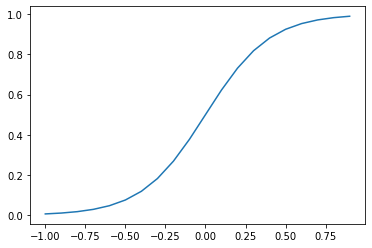

In [8]:
def sigmoid(x, k=5.0):
    return 1.0/(1.0+np.exp(-k*x))

x = np.arange(-1.0, 1.0, 0.1) 
y = sigmoid(x) 
plt.plot(x, y)
plt.show()

55- Added channel_scale so the convolution can be minimized by searching a single value rather the norm of the convolution
- ConvBR::Forward, rather than scaling the convlution weights, I can scale the convolution output of all batches and convolutions by sigmoid(sigmoid_scale*cannel_scale)
```python
        x = self.conv(x)
        if self.search_structure: #scale channels based on 
            weight_scale = self.sigmoid(self.sigmoid_scale*self.channel_scale)[None,:,None,None]
            x *= weight_scale
```
- CpmvBR::ArchitectureWeights scales the architecture weight convolution norm by (sigmoid_scale*channel_scale):
```python
        weight_scale = self.sigmoid(self.sigmoid_scale*self.channel_scale)
        conv_weights = torch.tanh(self.weight_gain*weight_scale*torch.linalg.norm(self.conv.weight, dim=(1,2,3)))
```
- sigmoid scale = 5 transitions from ~0 at -1 to ~1 at 1.  Not necessary but it it makes me happy to have the weights normalized in that range
- This resulted in a much more agressive pruning
<br /> ![nas_20220110_00 cell weights](../img/nas_20220110_00_cw.png) <br />
- Accuracy converged well with test tracking training effectively
<br /> ![nas_20220110_00 Tensorboard](../img/nas_20220110_00_tb.png) <br />
- Pruning was too effective but not reflected in search weight.  Add pruning information to ConvBR::ApplyStructure so the convoluation weight an pruning is clear that results in everything being pruned.
- Why didn't the plot show everything was being pruned?  
```cmd
Total Trainable Params: 38146522
ConvBR::ApplyStructure Cell 0 convolution 0/3 1.0=64/64 in_channels=3 out_channels=0
ConvBR::ApplyStructure Cell 0 convolution 1/3 1.0=64/64 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 0 convolution 2/3 1.0=256/256 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 0 cell residual 1.0=256/256 in_channels=3 out_channels=0
ConvBR::ApplyStructure Cell 1 convolution 0/3 1.0=64/64 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 1 convolution 1/3 1.0=64/64 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 1 convolution 2/3 1.0=256/256 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 1 cell residual 1.0=256/256 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 2 convolution 0/3 1.0=64/64 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 2 convolution 1/3 1.0=64/64 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 2 convolution 2/3 1.0=256/256 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 2 cell residual 1.0=256/256 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 3 convolution 0/3 1.0=128/128 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 3 convolution 1/3 1.0=128/128 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 3 convolution 2/3 1.0=512/512 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 3 cell residual 1.0=512/512 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 4 convolution 0/3 1.0=128/128 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 4 convolution 1/3 1.0=128/128 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 4 convolution 2/3 1.0=512/512 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 4 cell residual 1.0=512/512 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 5 convolution 0/3 1.0=128/128 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 5 convolution 1/3 1.0=128/128 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 5 convolution 2/3 1.0=512/512 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 5 cell residual 1.0=512/512 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 6 convolution 0/3 1.0=128/128 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 6 convolution 1/3 1.0=128/128 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 6 convolution 2/3 1.0=512/512 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 6 cell residual 1.0=512/512 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 7 convolution 0/3 1.0=256/256 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 7 convolution 1/3 1.0=256/256 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 7 convolution 2/3 1.0=1024/1024 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 7 cell residual 1.0=1024/1024 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 8 convolution 0/3 1.0=256/256 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 8 convolution 1/3 1.0=256/256 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 8 convolution 2/3 1.0=1024/1024 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 8 cell residual 1.0=1024/1024 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 9 convolution 0/3 1.0=256/256 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 9 convolution 1/3 1.0=256/256 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 9 convolution 2/3 1.0=1024/1024 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 9 cell residual 1.0=1024/1024 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 10 convolution 0/3 1.0=256/256 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 10 convolution 1/3 1.0=256/256 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 10 convolution 2/3 1.0=1024/1024 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 10 cell residual 1.0=1024/1024 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 11 convolution 0/3 1.0=256/256 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 11 convolution 1/3 1.0=256/256 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 11 convolution 2/3 1.0=1024/1024 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 11 cell residual 1.0=1024/1024 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 12 convolution 0/3 1.0=256/256 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 12 convolution 1/3 1.0=256/256 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 12 convolution 2/3 1.0=1024/1024 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 12 cell residual 1.0=1024/1024 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 13 convolution 0/3 1.0=512/512 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 13 convolution 1/3 1.0=512/512 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 13 convolution 2/3 1.0=2048/2048 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 13 cell residual 1.0=2048/2048 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 14 convolution 0/3 1.0=512/512 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 14 convolution 1/3 1.0=512/512 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 14 convolution 2/3 1.0=2048/2048 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 14 cell residual 1.0=2048/2048 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 15 convolution 0/3 1.0=512/512 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 15 convolution 1/3 1.0=512/512 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 15 convolution 2/3 1.0=2048/2048 in_channels=0 out_channels=0
ConvBR::ApplyStructure Cell 15 cell residual 1.0=2048/2048 in_channels=0 out_channels=0
FC::ApplyStructure in 1.0=2048/2048 out 0.0=0/10 convolutions in_channels=0 out_channels=10
+-------------------------------------------+------------+
|                  Modules                  | Parameters |
+-------------------------------------------+------------+
|          cells.0.cell_convolution         |     1      |
|        cells.0.cnn.0.channel_scale        |     64     |
|         cells.0.cnn.0.conv.weight         |     0      |
|          cells.0.cnn.0.conv.bias          |     0      |
|      cells.0.cnn.0.batchnorm2d.weight     |     0      |
|       cells.0.cnn.0.batchnorm2d.bias      |     0      |
|        cells.0.cnn.1.channel_scale        |     64     |
|         cells.0.cnn.1.conv.weight         |     0      |
|          cells.0.cnn.1.conv.bias          |     0      |
|      cells.0.cnn.1.batchnorm2d.weight     |     0      |
|       cells.0.cnn.1.batchnorm2d.bias      |     0      |
|        cells.0.cnn.2.channel_scale        |    256     |
|         cells.0.cnn.2.conv.weight         |     0      |
|          cells.0.cnn.2.conv.bias          |     0      |
|      cells.0.cnn.2.batchnorm2d.weight     |     0      |
|       cells.0.cnn.2.batchnorm2d.bias      |     0      |
|    cells.0.conv_residual.channel_scale    |    256     |
|     cells.0.conv_residual.conv.weight     |     0      |
|      cells.0.conv_residual.conv.bias      |     0      |
|  cells.0.conv_residual.batchnorm2d.weight |     0      |
|   cells.0.conv_residual.batchnorm2d.bias  |     0      |
|          cells.1.cell_convolution         |     1      |
|        cells.1.cnn.0.channel_scale        |     64     |
|         cells.1.cnn.0.conv.weight         |     0      |
|          cells.1.cnn.0.conv.bias          |     0      |
|      cells.1.cnn.0.batchnorm2d.weight     |     0      |
|       cells.1.cnn.0.batchnorm2d.bias      |     0      |
|        cells.1.cnn.1.channel_scale        |     64     |
|         cells.1.cnn.1.conv.weight         |     0      |
|          cells.1.cnn.1.conv.bias          |     0      |
|      cells.1.cnn.1.batchnorm2d.weight     |     0      |
|       cells.1.cnn.1.batchnorm2d.bias      |     0      |
|        cells.1.cnn.2.channel_scale        |    256     |
|         cells.1.cnn.2.conv.weight         |     0      |
|          cells.1.cnn.2.conv.bias          |     0      |
|      cells.1.cnn.2.batchnorm2d.weight     |     0      |
|       cells.1.cnn.2.batchnorm2d.bias      |     0      |
|    cells.1.conv_residual.channel_scale    |    256     |
|     cells.1.conv_residual.conv.weight     |     0      |
|      cells.1.conv_residual.conv.bias      |     0      |
|  cells.1.conv_residual.batchnorm2d.weight |     0      |
|   cells.1.conv_residual.batchnorm2d.bias  |     0      |
|          cells.2.cell_convolution         |     1      |
|        cells.2.cnn.0.channel_scale        |     64     |
|         cells.2.cnn.0.conv.weight         |     0      |
|          cells.2.cnn.0.conv.bias          |     0      |
|      cells.2.cnn.0.batchnorm2d.weight     |     0      |
|       cells.2.cnn.0.batchnorm2d.bias      |     0      |
|        cells.2.cnn.1.channel_scale        |     64     |
|         cells.2.cnn.1.conv.weight         |     0      |
|          cells.2.cnn.1.conv.bias          |     0      |
|      cells.2.cnn.1.batchnorm2d.weight     |     0      |
|       cells.2.cnn.1.batchnorm2d.bias      |     0      |
|        cells.2.cnn.2.channel_scale        |    256     |
|         cells.2.cnn.2.conv.weight         |     0      |
|          cells.2.cnn.2.conv.bias          |     0      |
|      cells.2.cnn.2.batchnorm2d.weight     |     0      |
|       cells.2.cnn.2.batchnorm2d.bias      |     0      |
|    cells.2.conv_residual.channel_scale    |    256     |
|     cells.2.conv_residual.conv.weight     |     0      |
|      cells.2.conv_residual.conv.bias      |     0      |
|  cells.2.conv_residual.batchnorm2d.weight |     0      |
|   cells.2.conv_residual.batchnorm2d.bias  |     0      |
|          cells.3.cell_convolution         |     1      |
|        cells.3.cnn.0.channel_scale        |    128     |
|         cells.3.cnn.0.conv.weight         |     0      |
|          cells.3.cnn.0.conv.bias          |     0      |
|      cells.3.cnn.0.batchnorm2d.weight     |     0      |
|       cells.3.cnn.0.batchnorm2d.bias      |     0      |
|        cells.3.cnn.1.channel_scale        |    128     |
|         cells.3.cnn.1.conv.weight         |     0      |
|          cells.3.cnn.1.conv.bias          |     0      |
|      cells.3.cnn.1.batchnorm2d.weight     |     0      |
|       cells.3.cnn.1.batchnorm2d.bias      |     0      |
|        cells.3.cnn.2.channel_scale        |    512     |
|         cells.3.cnn.2.conv.weight         |     0      |
|          cells.3.cnn.2.conv.bias          |     0      |
|      cells.3.cnn.2.batchnorm2d.weight     |     0      |
|       cells.3.cnn.2.batchnorm2d.bias      |     0      |
|    cells.3.conv_residual.channel_scale    |    512     |
|     cells.3.conv_residual.conv.weight     |     0      |
|      cells.3.conv_residual.conv.bias      |     0      |
|  cells.3.conv_residual.batchnorm2d.weight |     0      |
|   cells.3.conv_residual.batchnorm2d.bias  |     0      |
|          cells.4.cell_convolution         |     1      |
|        cells.4.cnn.0.channel_scale        |    128     |
|         cells.4.cnn.0.conv.weight         |     0      |
|          cells.4.cnn.0.conv.bias          |     0      |
|      cells.4.cnn.0.batchnorm2d.weight     |     0      |
|       cells.4.cnn.0.batchnorm2d.bias      |     0      |
|        cells.4.cnn.1.channel_scale        |    128     |
|         cells.4.cnn.1.conv.weight         |     0      |
|          cells.4.cnn.1.conv.bias          |     0      |
|      cells.4.cnn.1.batchnorm2d.weight     |     0      |
|       cells.4.cnn.1.batchnorm2d.bias      |     0      |
|        cells.4.cnn.2.channel_scale        |    512     |
|         cells.4.cnn.2.conv.weight         |     0      |
|          cells.4.cnn.2.conv.bias          |     0      |
|      cells.4.cnn.2.batchnorm2d.weight     |     0      |
|       cells.4.cnn.2.batchnorm2d.bias      |     0      |
|    cells.4.conv_residual.channel_scale    |    512     |
|     cells.4.conv_residual.conv.weight     |     0      |
|      cells.4.conv_residual.conv.bias      |     0      |
|  cells.4.conv_residual.batchnorm2d.weight |     0      |
|   cells.4.conv_residual.batchnorm2d.bias  |     0      |
|          cells.5.cell_convolution         |     1      |
|        cells.5.cnn.0.channel_scale        |    128     |
|         cells.5.cnn.0.conv.weight         |     0      |
|          cells.5.cnn.0.conv.bias          |     0      |
|      cells.5.cnn.0.batchnorm2d.weight     |     0      |
|       cells.5.cnn.0.batchnorm2d.bias      |     0      |
|        cells.5.cnn.1.channel_scale        |    128     |
|         cells.5.cnn.1.conv.weight         |     0      |
|          cells.5.cnn.1.conv.bias          |     0      |
|      cells.5.cnn.1.batchnorm2d.weight     |     0      |
|       cells.5.cnn.1.batchnorm2d.bias      |     0      |
|        cells.5.cnn.2.channel_scale        |    512     |
|         cells.5.cnn.2.conv.weight         |     0      |
|          cells.5.cnn.2.conv.bias          |     0      |
|      cells.5.cnn.2.batchnorm2d.weight     |     0      |
|       cells.5.cnn.2.batchnorm2d.bias      |     0      |
|    cells.5.conv_residual.channel_scale    |    512     |
|     cells.5.conv_residual.conv.weight     |     0      |
|      cells.5.conv_residual.conv.bias      |     0      |
|  cells.5.conv_residual.batchnorm2d.weight |     0      |
|   cells.5.conv_residual.batchnorm2d.bias  |     0      |
|          cells.6.cell_convolution         |     1      |
|        cells.6.cnn.0.channel_scale        |    128     |
|         cells.6.cnn.0.conv.weight         |     0      |
|          cells.6.cnn.0.conv.bias          |     0      |
|      cells.6.cnn.0.batchnorm2d.weight     |     0      |
|       cells.6.cnn.0.batchnorm2d.bias      |     0      |
|        cells.6.cnn.1.channel_scale        |    128     |
|         cells.6.cnn.1.conv.weight         |     0      |
|          cells.6.cnn.1.conv.bias          |     0      |
|      cells.6.cnn.1.batchnorm2d.weight     |     0      |
|       cells.6.cnn.1.batchnorm2d.bias      |     0      |
|        cells.6.cnn.2.channel_scale        |    512     |
|         cells.6.cnn.2.conv.weight         |     0      |
|          cells.6.cnn.2.conv.bias          |     0      |
|      cells.6.cnn.2.batchnorm2d.weight     |     0      |
|       cells.6.cnn.2.batchnorm2d.bias      |     0      |
|    cells.6.conv_residual.channel_scale    |    512     |
|     cells.6.conv_residual.conv.weight     |     0      |
|      cells.6.conv_residual.conv.bias      |     0      |
|  cells.6.conv_residual.batchnorm2d.weight |     0      |
|   cells.6.conv_residual.batchnorm2d.bias  |     0      |
|          cells.7.cell_convolution         |     1      |
|        cells.7.cnn.0.channel_scale        |    256     |
|         cells.7.cnn.0.conv.weight         |     0      |
|          cells.7.cnn.0.conv.bias          |     0      |
|      cells.7.cnn.0.batchnorm2d.weight     |     0      |
|       cells.7.cnn.0.batchnorm2d.bias      |     0      |
|        cells.7.cnn.1.channel_scale        |    256     |
|         cells.7.cnn.1.conv.weight         |     0      |
|          cells.7.cnn.1.conv.bias          |     0      |
|      cells.7.cnn.1.batchnorm2d.weight     |     0      |
|       cells.7.cnn.1.batchnorm2d.bias      |     0      |
|        cells.7.cnn.2.channel_scale        |    1024    |
|         cells.7.cnn.2.conv.weight         |     0      |
|          cells.7.cnn.2.conv.bias          |     0      |
|      cells.7.cnn.2.batchnorm2d.weight     |     0      |
|       cells.7.cnn.2.batchnorm2d.bias      |     0      |
|    cells.7.conv_residual.channel_scale    |    1024    |
|     cells.7.conv_residual.conv.weight     |     0      |
|      cells.7.conv_residual.conv.bias      |     0      |
|  cells.7.conv_residual.batchnorm2d.weight |     0      |
|   cells.7.conv_residual.batchnorm2d.bias  |     0      |
|          cells.8.cell_convolution         |     1      |
|        cells.8.cnn.0.channel_scale        |    256     |
|         cells.8.cnn.0.conv.weight         |     0      |
|          cells.8.cnn.0.conv.bias          |     0      |
|      cells.8.cnn.0.batchnorm2d.weight     |     0      |
|       cells.8.cnn.0.batchnorm2d.bias      |     0      |
|        cells.8.cnn.1.channel_scale        |    256     |
|         cells.8.cnn.1.conv.weight         |     0      |
|          cells.8.cnn.1.conv.bias          |     0      |
|      cells.8.cnn.1.batchnorm2d.weight     |     0      |
|       cells.8.cnn.1.batchnorm2d.bias      |     0      |
|        cells.8.cnn.2.channel_scale        |    1024    |
|         cells.8.cnn.2.conv.weight         |     0      |
|          cells.8.cnn.2.conv.bias          |     0      |
|      cells.8.cnn.2.batchnorm2d.weight     |     0      |
|       cells.8.cnn.2.batchnorm2d.bias      |     0      |
|    cells.8.conv_residual.channel_scale    |    1024    |
|     cells.8.conv_residual.conv.weight     |     0      |
|      cells.8.conv_residual.conv.bias      |     0      |
|  cells.8.conv_residual.batchnorm2d.weight |     0      |
|   cells.8.conv_residual.batchnorm2d.bias  |     0      |
|          cells.9.cell_convolution         |     1      |
|        cells.9.cnn.0.channel_scale        |    256     |
|         cells.9.cnn.0.conv.weight         |     0      |
|          cells.9.cnn.0.conv.bias          |     0      |
|      cells.9.cnn.0.batchnorm2d.weight     |     0      |
|       cells.9.cnn.0.batchnorm2d.bias      |     0      |
|        cells.9.cnn.1.channel_scale        |    256     |
|         cells.9.cnn.1.conv.weight         |     0      |
|          cells.9.cnn.1.conv.bias          |     0      |
|      cells.9.cnn.1.batchnorm2d.weight     |     0      |
|       cells.9.cnn.1.batchnorm2d.bias      |     0      |
|        cells.9.cnn.2.channel_scale        |    1024    |
|         cells.9.cnn.2.conv.weight         |     0      |
|          cells.9.cnn.2.conv.bias          |     0      |
|      cells.9.cnn.2.batchnorm2d.weight     |     0      |
|       cells.9.cnn.2.batchnorm2d.bias      |     0      |
|    cells.9.conv_residual.channel_scale    |    1024    |
|     cells.9.conv_residual.conv.weight     |     0      |
|      cells.9.conv_residual.conv.bias      |     0      |
|  cells.9.conv_residual.batchnorm2d.weight |     0      |
|   cells.9.conv_residual.batchnorm2d.bias  |     0      |
|         cells.10.cell_convolution         |     1      |
|        cells.10.cnn.0.channel_scale       |    256     |
|         cells.10.cnn.0.conv.weight        |     0      |
|          cells.10.cnn.0.conv.bias         |     0      |
|     cells.10.cnn.0.batchnorm2d.weight     |     0      |
|      cells.10.cnn.0.batchnorm2d.bias      |     0      |
|        cells.10.cnn.1.channel_scale       |    256     |
|         cells.10.cnn.1.conv.weight        |     0      |
|          cells.10.cnn.1.conv.bias         |     0      |
|     cells.10.cnn.1.batchnorm2d.weight     |     0      |
|      cells.10.cnn.1.batchnorm2d.bias      |     0      |
|        cells.10.cnn.2.channel_scale       |    1024    |
|         cells.10.cnn.2.conv.weight        |     0      |
|          cells.10.cnn.2.conv.bias         |     0      |
|     cells.10.cnn.2.batchnorm2d.weight     |     0      |
|      cells.10.cnn.2.batchnorm2d.bias      |     0      |
|    cells.10.conv_residual.channel_scale   |    1024    |
|     cells.10.conv_residual.conv.weight    |     0      |
|      cells.10.conv_residual.conv.bias     |     0      |
| cells.10.conv_residual.batchnorm2d.weight |     0      |
|  cells.10.conv_residual.batchnorm2d.bias  |     0      |
|         cells.11.cell_convolution         |     1      |
|        cells.11.cnn.0.channel_scale       |    256     |
|         cells.11.cnn.0.conv.weight        |     0      |
|          cells.11.cnn.0.conv.bias         |     0      |
|     cells.11.cnn.0.batchnorm2d.weight     |     0      |
|      cells.11.cnn.0.batchnorm2d.bias      |     0      |
|        cells.11.cnn.1.channel_scale       |    256     |
|         cells.11.cnn.1.conv.weight        |     0      |
|          cells.11.cnn.1.conv.bias         |     0      |
|     cells.11.cnn.1.batchnorm2d.weight     |     0      |
|      cells.11.cnn.1.batchnorm2d.bias      |     0      |
|        cells.11.cnn.2.channel_scale       |    1024    |
|         cells.11.cnn.2.conv.weight        |     0      |
|          cells.11.cnn.2.conv.bias         |     0      |
|     cells.11.cnn.2.batchnorm2d.weight     |     0      |
|      cells.11.cnn.2.batchnorm2d.bias      |     0      |
|    cells.11.conv_residual.channel_scale   |    1024    |
|     cells.11.conv_residual.conv.weight    |     0      |
|      cells.11.conv_residual.conv.bias     |     0      |
| cells.11.conv_residual.batchnorm2d.weight |     0      |
|  cells.11.conv_residual.batchnorm2d.bias  |     0      |
|         cells.12.cell_convolution         |     1      |
|        cells.12.cnn.0.channel_scale       |    256     |
|         cells.12.cnn.0.conv.weight        |     0      |
|          cells.12.cnn.0.conv.bias         |     0      |
|     cells.12.cnn.0.batchnorm2d.weight     |     0      |
|      cells.12.cnn.0.batchnorm2d.bias      |     0      |
|        cells.12.cnn.1.channel_scale       |    256     |
|         cells.12.cnn.1.conv.weight        |     0      |
|          cells.12.cnn.1.conv.bias         |     0      |
|     cells.12.cnn.1.batchnorm2d.weight     |     0      |
|      cells.12.cnn.1.batchnorm2d.bias      |     0      |
|        cells.12.cnn.2.channel_scale       |    1024    |
|         cells.12.cnn.2.conv.weight        |     0      |
|          cells.12.cnn.2.conv.bias         |     0      |
|     cells.12.cnn.2.batchnorm2d.weight     |     0      |
|      cells.12.cnn.2.batchnorm2d.bias      |     0      |
|    cells.12.conv_residual.channel_scale   |    1024    |
|     cells.12.conv_residual.conv.weight    |     0      |
|      cells.12.conv_residual.conv.bias     |     0      |
| cells.12.conv_residual.batchnorm2d.weight |     0      |
|  cells.12.conv_residual.batchnorm2d.bias  |     0      |
|         cells.13.cell_convolution         |     1      |
|        cells.13.cnn.0.channel_scale       |    512     |
|         cells.13.cnn.0.conv.weight        |     0      |
|          cells.13.cnn.0.conv.bias         |     0      |
|     cells.13.cnn.0.batchnorm2d.weight     |     0      |
|      cells.13.cnn.0.batchnorm2d.bias      |     0      |
|        cells.13.cnn.1.channel_scale       |    512     |
|         cells.13.cnn.1.conv.weight        |     0      |
|          cells.13.cnn.1.conv.bias         |     0      |
|     cells.13.cnn.1.batchnorm2d.weight     |     0      |
|      cells.13.cnn.1.batchnorm2d.bias      |     0      |
|        cells.13.cnn.2.channel_scale       |    2048    |
|         cells.13.cnn.2.conv.weight        |     0      |
|          cells.13.cnn.2.conv.bias         |     0      |
|     cells.13.cnn.2.batchnorm2d.weight     |     0      |
|      cells.13.cnn.2.batchnorm2d.bias      |     0      |
|    cells.13.conv_residual.channel_scale   |    2048    |
|     cells.13.conv_residual.conv.weight    |     0      |
|      cells.13.conv_residual.conv.bias     |     0      |
| cells.13.conv_residual.batchnorm2d.weight |     0      |
|  cells.13.conv_residual.batchnorm2d.bias  |     0      |
|         cells.14.cell_convolution         |     1      |
|        cells.14.cnn.0.channel_scale       |    512     |
|         cells.14.cnn.0.conv.weight        |     0      |
|          cells.14.cnn.0.conv.bias         |     0      |
|     cells.14.cnn.0.batchnorm2d.weight     |     0      |
|      cells.14.cnn.0.batchnorm2d.bias      |     0      |
|        cells.14.cnn.1.channel_scale       |    512     |
|         cells.14.cnn.1.conv.weight        |     0      |
|          cells.14.cnn.1.conv.bias         |     0      |
|     cells.14.cnn.1.batchnorm2d.weight     |     0      |
|      cells.14.cnn.1.batchnorm2d.bias      |     0      |
|        cells.14.cnn.2.channel_scale       |    2048    |
|         cells.14.cnn.2.conv.weight        |     0      |
|          cells.14.cnn.2.conv.bias         |     0      |
|     cells.14.cnn.2.batchnorm2d.weight     |     0      |
|      cells.14.cnn.2.batchnorm2d.bias      |     0      |
|    cells.14.conv_residual.channel_scale   |    2048    |
|     cells.14.conv_residual.conv.weight    |     0      |
|      cells.14.conv_residual.conv.bias     |     0      |
| cells.14.conv_residual.batchnorm2d.weight |     0      |
|  cells.14.conv_residual.batchnorm2d.bias  |     0      |
|         cells.15.cell_convolution         |     1      |
|        cells.15.cnn.0.channel_scale       |    512     |
|         cells.15.cnn.0.conv.weight        |     0      |
|          cells.15.cnn.0.conv.bias         |     0      |
|     cells.15.cnn.0.batchnorm2d.weight     |     0      |
|      cells.15.cnn.0.batchnorm2d.bias      |     0      |
|        cells.15.cnn.1.channel_scale       |    512     |
|         cells.15.cnn.1.conv.weight        |     0      |
|          cells.15.cnn.1.conv.bias         |     0      |
|     cells.15.cnn.1.batchnorm2d.weight     |     0      |
|      cells.15.cnn.1.batchnorm2d.bias      |     0      |
|        cells.15.cnn.2.channel_scale       |    2048    |
|         cells.15.cnn.2.conv.weight        |     0      |
|          cells.15.cnn.2.conv.bias         |     0      |
|     cells.15.cnn.2.batchnorm2d.weight     |     0      |
|      cells.15.cnn.2.batchnorm2d.bias      |     0      |
|    cells.15.conv_residual.channel_scale   |    2048    |
|     cells.15.conv_residual.conv.weight    |     0      |
|      cells.15.conv_residual.conv.bias     |     0      |
| cells.15.conv_residual.batchnorm2d.weight |     0      |
|  cells.15.conv_residual.batchnorm2d.bias  |     0      |
|                fc.fc.weight               |     0      |
|                 fc.fc.bias                |     10     |
+-------------------------------------------+------------+
Total Trainable Params: 37786
Reduced parameters 37786/38146522 = 0.0009905490204323215
Traceback (most recent call last):
  File "networks/cell2d.py", line 1049, in <module>
    result = Test(args)
  File "networks/cell2d.py", line 929, in Test
    plotsearch = PlotSearch(classify)
  File "networks/cell2d.py", line 785, in __init__
    architecture_weights, total_trainable_weights, cell_weights = network.ArchitectureWeights()
  File "networks/cell2d.py", line 703, in ArchitectureWeights
    cell_archatecture_weights, cell_total_trainable_weights, cell_weight = in_cell.ArchitectureWeights()
  File "networks/cell2d.py", line 463, in ArchitectureWeights
    layer_weight, _, conv_weights  = l.ArchitectureWeights()
  File "networks/cell2d.py", line 151, in ArchitectureWeights
    conv_weights = torch.tanh(self.weight_gain*weight_scale*torch.linalg.norm(self.conv.weight, dim=(1,2,3)))
RuntimeError: The size of tensor a (64) must match the size of tensor b (0) at non-singleton dimension 0
PlotSearch finish
```

12 January 2022
- Error in normalized weights is because L2 norm is not normzlized based on the number of elments in norm.  The norm of large convolutions resulted in a larger norm than smaller convolutions.
- L2 norm devided by the square root of the number of elements results in consistent bahavior across different tensor sizes:
``` python
def ArchitectureWeights(self):
    weight_scale = self.sigmoid(self.sigmoid_scale*self.channel_scale)
    norm = torch.linalg.norm(self.conv.weight, dim=(1,2,3))/np.sqrt(np.product(self.conv.weight.shape[1:]))
    conv_weights = torch.tanh(self.weight_gain*weight_scale*norm)
```
- Next, include a by-stable function in the objective for channel enable/disable so the optomizer will be rewarded for either turning the channel on or off and avoid a middle value
- How to handel zeroing out all convolutions?
- Disabled batch norm to prevent compensating for a zeroed out channel by brining it back with batch norm.

13 January 2022
- Training was resulting in zero-sized convolutions
- Cause - initialized channel pruning to 0.5.  
- Architecture wights was product of convolution norm (~ 0.6) * channel scale (~0.5) = ~0.3
- Cutoff was 0.5 = results in pruning all of the convolutions
- 
``` python
class ConvBR(nn.Module):
    def __init__(self, 
       self.channel_scale = nn.Parameter(torch.zeros(self.out_channels, dtype=torch.float))
    def ArchitectureWeights(self):
        weight_scale = self.sigmoid(self.sigmoid_scale*self.channel_scale)
        conv_weights = torch.tanh(self.weight_gain*weight_scale*torch.linalg.norm(self.conv.weight, dim=(1,2,3)))

```
- Fix: change con_weights average of channel_scale and convolutio norm
```python
    def ArchitectureWeights(self):
        weight_scale = self.sigmoid(self.sigmoid_scale*self.channel_scale)
        norm = torch.linalg.norm(self.conv.weight, dim=(1,2,3))/np.sqrt(np.product(self.conv.weight.shape[1:]))
        conv_weights = (torch.tanh(self.weight_gain*norm)+weight_scale)/2.0

```
- I then needed to reduce the -k_structure default argument (trying 1e-3 now) to accuracy is searched preferentially.
- Add stabilization normalized gaussian function to push ConvBR::channel_scale to 0 or 1.  Add to loss so channels preferentially are on or off
- record class weights as video
- Add class weighs to tensorboard
- What d cleass weights do when search_structure us false?
- Add fully connected layer to model erosion
- How to esnsure the eroded model is feasible?
- Eroded weights should not be contributing significantly to model accuracy.  
- Is relaxation of the convolution outputs a poor model of the removed weight?  
- Do max pooling and batch normalizaton compensate too effectively for the weight change?


14 January 2022
- The trained networks were very stubborn about minimizing network size
- After initial training without or with very little pruning, I then tried to increase the pruning with very little affect
- Added a gradient plot following the structure of the class_weights plot
- Found that the architecture gradent was in the trange of 1e-6 and the classification gradient was in the range of 1e-2
- By increasing k_structure, I was able to proportionally incrase the class weight norms to a similar value to classificaiton norms
- At this point, classificaiton loss on the test set minimized at a bout 1000 batches and then incrased.  
- Set structural loss to target a specific architecture level and  trained.

15 January 2022
- Added gradient norm visualization
- Needed to increase k_structure to 1.0e2 or 1.0e3 to get the structure minimization.  1.0e3 convers structure well
- Need to handle 0 size convolution

17 January 2022
- Added image augmentation, removed dropout
- CIFAR-10 Resnet 18, 75 epochs, -target_structure=1.0e0, final test accuracy ~0.8583, nas_20220117_rn18_00
- CIFAR-10 Resnet 18, 20 epochs, -target_structure=1.0e0, -learning_rate=0.001, final test accuracy ~0.8743, nas_20220117_rn18_01
- CIFSR-10 -target_structure=1.0e-1, 10 epochs, -learning_rate=0.01, -target_structure=1.0e-1, final test accuracy ~.8496, nas_20220117_rn18_02
- CIFAR-10 Resnet 18, 20 epochs, Prune, Reduced parameters 5145795/11498898 = 0.4475033172744032, -learning_rate=0.001,
learning_rate=0.01, -target_structure=1.0e-1, final test accuracy ~.8496, nas_20220117_rn18_02
- nas_20220117_rn18_04 zero's out several channels.  Use this to figure out what I should do when this happens.  I would like to burn out the convolution and burn open the residual but that would mean growing the residual channel.  Maybe freezing the residual would be better.